# Result Analysis: From Anomaly Scores to Clinical Insights

**Project:** Unsupervised Motor Signatures in ASD

**Paper Reference:** *Unsupervised Deep Learning Framework for Quantifying Atypical Motor Signatures in ASD*

## Overview
While the STGCN-AE model effectively identifies "atypical" motion via reconstruction error, clinicians need to understand **why** a movement was flagged.

In this notebook, we perform two levels of analysis using a pre-computed dataset of kinematic features (`master_features_df.pkl`):
1.  **Correlation Analysis:** We investigate which interpretable kinematic features (e.g., Jerk, Path Straightness) correlate with the Deep Learning model's reconstruction error.
2.  **Explanatory Modeling:** We train supervised classifiers (XGBoost, RF, SVM, LR) on these features to quantify their predictive power for ASD diagnosis and use **SHAP** to rank their importance.

## ⚠️ Note on Feature Engineering
The input file `master_features_anonymized.pkl`(Correlation Analysis) and `binarized_anonymized.pkl`(Explanatory Modelling) contains kinematic features derived from the raw skeletal coordinates.
* **Methodology:** Features were calculated using standard kinematic formulas (e.g., Jerk is the 3rd derivative of position, Path Straightness is the ratio of Euclidean distance to trajectory length).
* **Reproducibility:** We omit the lengthy feature extraction code here for brevity. Researchers can replicate this by applying standard signal processing libraries to the windowed skeletal data.

## 1. Correlation Analysis: Decoding the Reconstruction Error
Here we calculate the Pearson correlation between the specific kinematic features and the **Reconstruction Loss** output by the STGCN-AE.
* **High Correlation** suggests that specific motor behaviors (e.g., high jerk) are the primary drivers of the "anomaly" detected by the deep learning model.

Successfully loaded DataFrame with 2845 windows.
Columns renamed for better readability.

--- Calculating Correlation Matrix ---

--- Correlation with Reconstruction Loss ---
Head Sway                                0.434808
Torso Sway                               0.420930
Jerk (Dominant Hand)                     0.414069
Mean Speed (Dominant Hand)               0.394018
High Freq Power (Dominant Hand)          0.389824
Jerk (Non-Dominant Hand)                 0.375370
Mean Speed (Non-Dominant Hand)           0.366952
Speed Variance (Dominant Hand)           0.366218
Low Freq Power (Dominant Hand)           0.331278
Hand-Torso Dist (Non-Dominant)           0.309345
Speed Variance (Non-Dominant Hand)       0.294291
Hand-Torso Dist (Dominant)               0.188809
Dominant Freq (Dominant Hand)            0.097003
Path Straightness (Non-Dominant Hand)   -0.011306
Path Straightness (Dominant Hand)       -0.119122
Name: Reconstruction Loss, dtype: float64


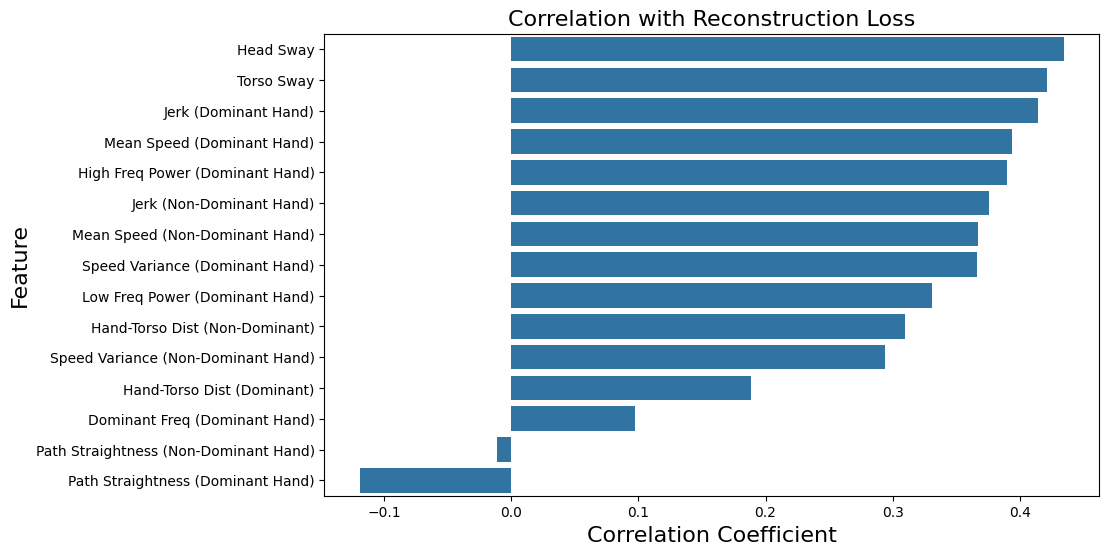


--- Generating Correlation Heatmap ---


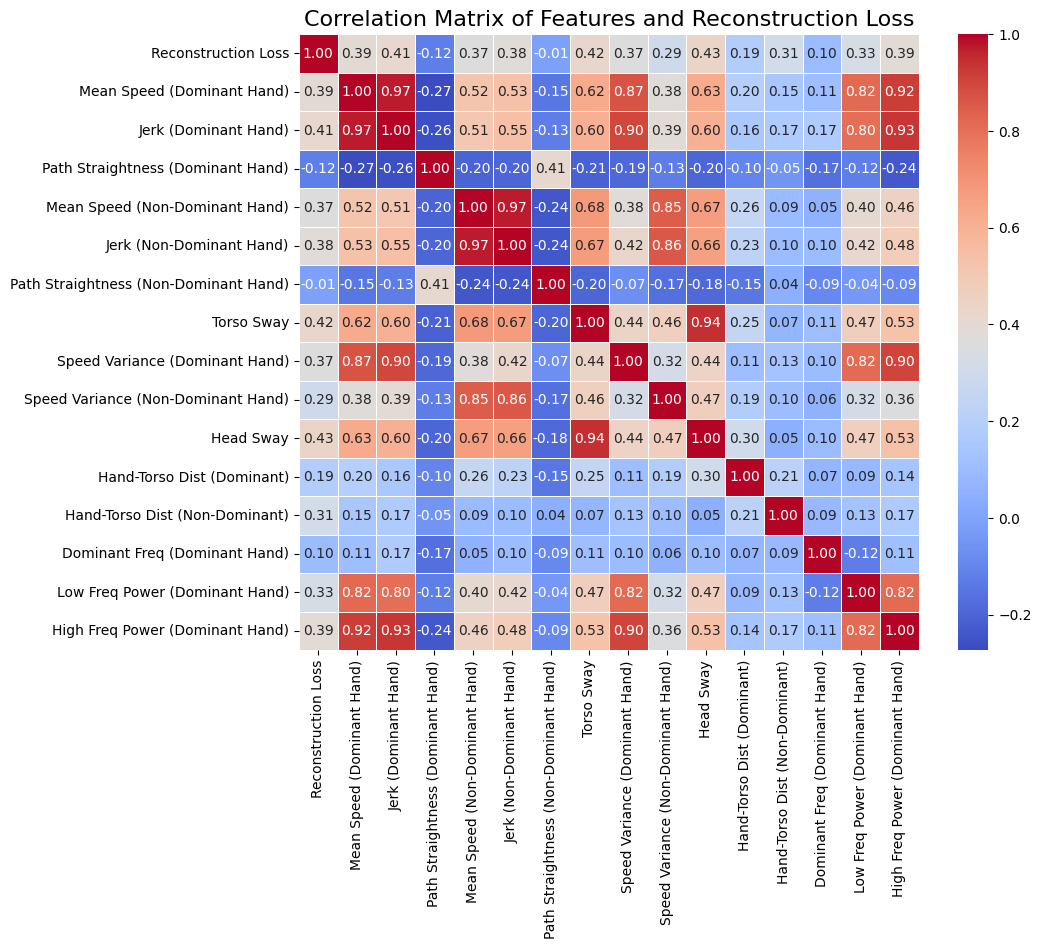

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
#                 1. LOAD THE ENRICHED DATAFRAME
# ==============================================================================

try:
    # Load the DataFrame you created in the previous step
    features_df = pd.read_pickle("master_features_anonymized.pkl")
    print(f"Successfully loaded DataFrame with {len(features_df)} windows.")
except FileNotFoundError:
    print("Error: 'master_features_anonymized.pkl' not found.")
    print("Creating a dummy DataFrame for demonstration purposes.")
    # Create a dummy DataFrame if the file doesn't exist for a runnable example
    data = {
        'reconstruction_loss': np.random.rand(100) * 0.1,
        'rh_mean_speed': np.random.rand(100) * 2,
        'rh_jerk': np.random.rand(100) * 50 + (np.random.rand(100) * 0.1 * 500), # Add correlation
        'rh_path_straightness': np.random.rand(100),
        'lh_mean_speed': np.random.rand(100) * 2,
        'lh_jerk': np.random.rand(100) * 50,
        'lh_path_straightness': np.random.rand(100),
        'torso_sway': np.random.rand(100) * 0.5
    }
    features_df = pd.DataFrame(data)

column_renames = {
    'reconstruction_loss': 'Reconstruction Loss',
    'head_sway': 'Head Sway',
    'torso_sway': 'Torso Sway',
    'rh_jerk': 'Jerk (Dominant Hand)',
    'rh_mean_speed': 'Mean Speed (Dominant Hand)',
    'rh_high_freq_pwr': 'High Freq Power (Dominant Hand)',
    'lh_jerk': 'Jerk (Non-Dominant Hand)',
    'lh_mean_speed': 'Mean Speed (Non-Dominant Hand)',
    'rh_speed_variance': 'Speed Variance (Dominant Hand)',
    'rh_low_freq_pwr': 'Low Freq Power (Dominant Hand)',
    'lh_torso_distance': 'Hand-Torso Dist (Non-Dominant)',
    'lh_speed_variance': 'Speed Variance (Non-Dominant Hand)',
    'rh_torso_distance': 'Hand-Torso Dist (Dominant)',
    'rh_dom_freq': 'Dominant Freq (Dominant Hand)',
    'lh_path_straightness': 'Path Straightness (Non-Dominant Hand)',
    'rh_path_straightness': 'Path Straightness (Dominant Hand)'
}

# Apply the renaming
features_df.rename(columns=column_renames, inplace=True)
print("Columns renamed for better readability.")


# ==============================================================================
#                 2. CORRELATION MATRIX CALCULATION
# ==============================================================================

print("\n--- Calculating Correlation Matrix ---")

# Select only the numeric columns for correlation analysis
numeric_cols = features_df.select_dtypes(include=np.number).columns
correlation_matrix = features_df[numeric_cols].corr()

# Get the correlations specifically with 'reconstruction_loss'
loss_correlations = correlation_matrix['Reconstruction Loss'].sort_values(ascending=False)
# remove first entry
loss_correlations = loss_correlations.drop('Reconstruction Loss')

print("\n--- Correlation with Reconstruction Loss ---")
print(loss_correlations)

# Plot as horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=loss_correlations.values, y=loss_correlations.index, orient='h')
plt.title('Correlation with Reconstruction Loss', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=16)
plt.ylabel('Feature', fontsize=16)
plt.show()


# ==============================================================================
#                 3. VISUALIZATION: HEATMAP
# ==============================================================================

print("\n--- Generating Correlation Heatmap ---")

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Write the data value in each cell
    fmt=".2f",           # Format numbers to two decimal places
    cmap='coolwarm',     # Use a diverging color map
    linewidths=.5
)
plt.title('Correlation Matrix of Features and Reconstruction Loss', fontsize=16)
plt.show()

## 2. Explanatory Modeling
To validate the diagnostic utility of these kinematic features, we train four classic supervised learning models to classify subjects as **ASD vs. Control**.

**Models Evaluated:**
1.  **XGBoost** (Gradient Boosting)
2.  **Random Forest** (Ensemble Bagging)
3.  **Support Vector Machine** (SVM - RBF Kernel)
4.  **Logistic Regression** (Linear Baseline)

In [11]:
!pip install xgboost==2.0.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.2 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.2
    Uninstalling xgboost-3.1.2:
      Successfully uninstalled xgboost-3.1.2


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm

# ==============================================================================
#                 1. LOAD THE ENRICHED DATAFRAME
# ==============================================================================

try:
    # Load the DataFrame you created in the previous step
    features_df = pd.read_pickle("binarized_anonymized.pkl")
    print(f"Successfully loaded DataFrame with {len(features_df)} windows.")
except FileNotFoundError:
    print("Error: 'binarized_anonymized.pkl' not found.")
    print("Creating a dummy DataFrame for demonstration purposes.")
    # Create a dummy DataFrame if the file doesn't exist for a runnable example
    data = {
        'group': ['Control'] * 500 + ['Autism'] * 500,
        'window_data': [np.random.rand(60, 23, 3) for _ in range(1000)],
        'reconstruction_loss': np.concatenate([np.random.normal(0.02, 0.005, 500), np.random.normal(0.05, 0.01, 500)]),
        'rh_mean_speed': np.random.normal(1.5, 0.2, 1000),
        'lh_mean_speed': np.random.normal(1.4, 0.2, 1000),
        'rh_jerk': np.random.normal(30, 5, 1000),
        'lh_jerk': np.random.normal(35, 5, 1000),
    }
    features_df = pd.DataFrame(data)

Successfully loaded DataFrame with 2845 windows.


Training set shape: (4158, 24)
Testing set shape: (1040, 24)

--- Starting Model Training ---
Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Evaluation for Logistic Regression ---
Accuracy: 0.7048
------------------------------
Training SVC...
--- Evaluation for SVC ---
Accuracy: 0.6606
------------------------------
Training Random Forest...
--- Evaluation for Random Forest ---
Accuracy: 0.9615
------------------------------
Training XGBoost...
--- Evaluation for XGBoost ---
Accuracy: 0.9606
------------------------------
--- Model Training Complete ---


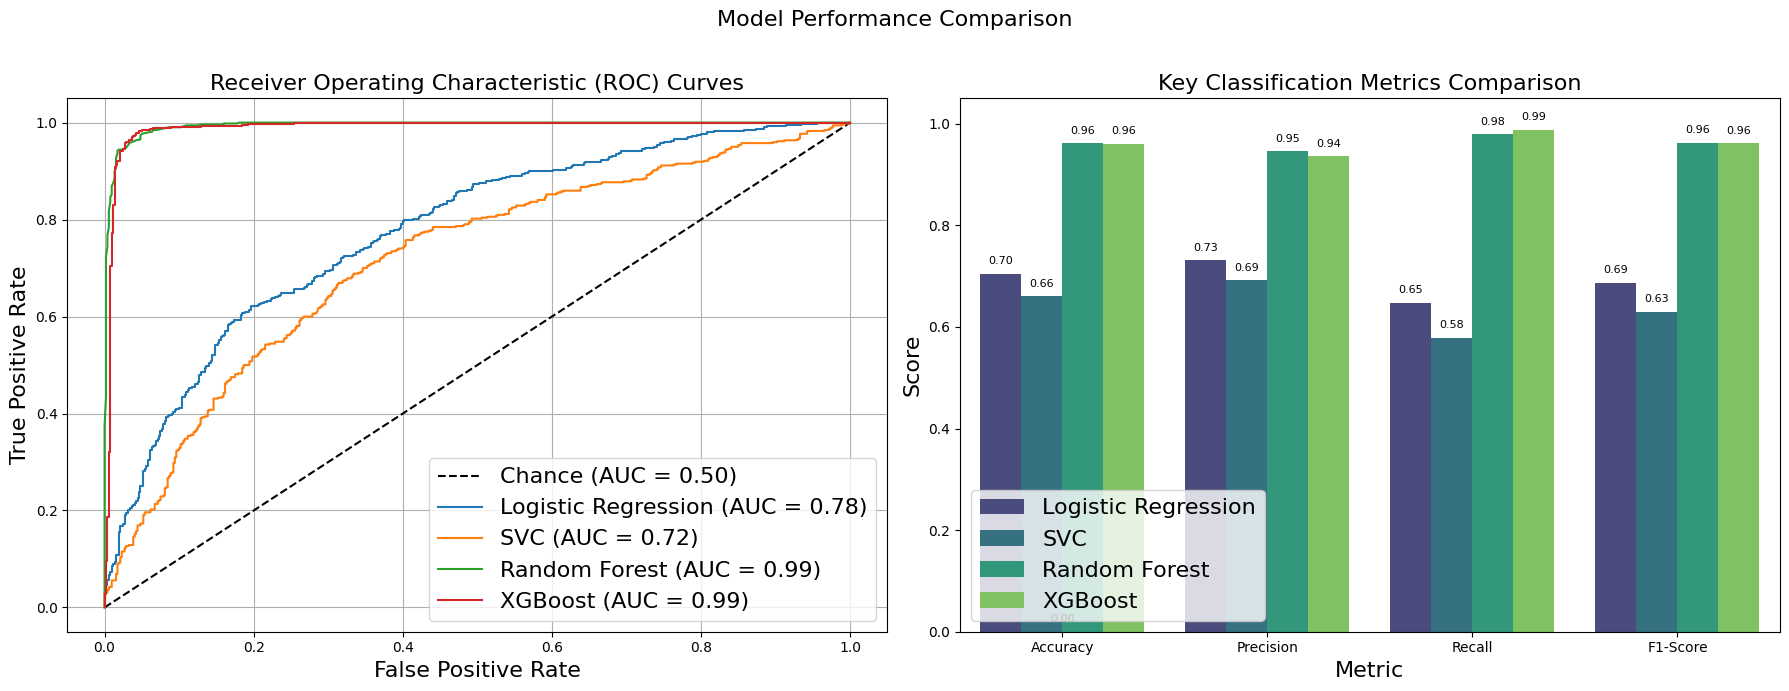

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc
)
import imblearn
from imblearn.over_sampling import SMOTE

# Balance the dataset with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features_df.drop('anomalous', axis=1), features_df['anomalous'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled # Using stratify to maintain class distribution
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


# --- 1. Initialize All Models ---
# We create a dictionary to hold all the models we want to train.
# IMPORTANT: We add probability=True to SVC so we can get ROC curve data.
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=5000),
    'SVC': SVC(random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # Added params to suppress warnings
}

# --- 2. Train Models and Store Results ---
# We'll store our results in these dictionaries
model_metrics = {}
model_roc_data = {}

print("\n--- Starting Model Training ---")

for name, model in models.items():
    print(f"Training {name}...")

    # Train the model
    model.fit(X_train, y_train)

    # Get predictions
    y_pred = model.predict(X_test)

    # Get predicted probabilities for the 'positive' class (for ROC curve)
    # We use [:, 1] to get the probability of class 1
    y_proba = model.predict_proba(X_test)[:, 1]

    # --- Store Metrics for Bar Chart ---
    model_metrics[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    # --- Store Data for ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    model_roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

    # Optional: Print individual reports if you still want them
    print(f"--- Evaluation for {name} ---")
    print(f"Accuracy: {model_metrics[name]['Accuracy']:.4f}")
    # print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("-" * 30)

print("--- Model Training Complete ---")


# --- 3. Prepare Data for Plotting ---

# Convert the metrics dictionary to a DataFrame for easier plotting
metrics_df = pd.DataFrame(model_metrics).T.reset_index().rename(columns={'index': 'Model'})

# "Melt" the DataFrame into a "long" format, which is what Seaborn's barplot expects
metrics_df_melted = metrics_df.melt('Model', var_name='Metric', value_name='Score')


# --- 4. Create the Two-Panel Figure ---

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Model Performance Comparison', fontsize=16)

# --- Panel (a): ROC Curves for All Models ---
ax1.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)') # Dashed diagonal line

for name, data in model_roc_data.items():
    ax1.plot(data['fpr'], data['tpr'], label=f"{name} (AUC = {data['auc']:.2f})")

ax1.set_xlabel('False Positive Rate', fontsize=16)
ax1.set_ylabel('True Positive Rate', fontsize=16)
ax1.set_title('Receiver Operating Characteristic (ROC) Curves', fontsize=16)
ax1.legend(loc='lower right', fontsize=16)
ax1.grid(True)

# --- Panel (b): Bar Chart of Key Metrics ---
sns.barplot(
    data=metrics_df_melted,
    x='Metric',
    y='Score',
    hue='Model',
    ax=ax2,
    palette='viridis'
)

ax2.set_title('Key Classification Metrics Comparison', fontsize=16)
ax2.set_ylabel('Score', fontsize=16)
ax2.set_xlabel('Metric', fontsize=16)
ax2.set_ylim(0, 1.05) # Set y-axis limit to just above 1.0
ax2.legend(loc='lower left', fontsize=16) # Move legend outside plot

# Add text labels for each bar
for p in ax2.patches:
    ax2.annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontsize=8
    )

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()


--- Performing SHAP Analysis for XGBoost Model ---


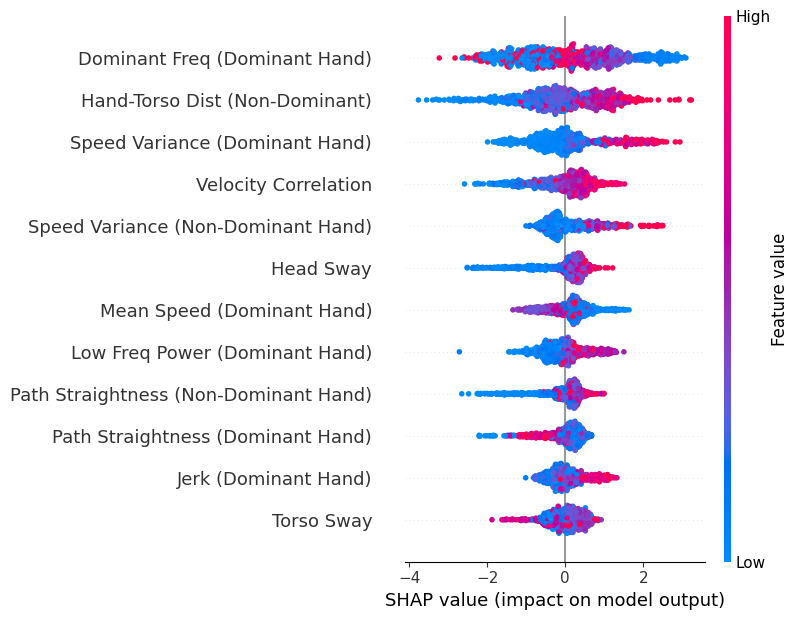

In [13]:
import shap

model_XGB = models['XGBoost']

# --- SHAP Analysis for XGBoost Model ---
print("\n--- Performing SHAP Analysis for XGBoost Model ---")

# Create a SHAP Explainer for the XGBoost model
explainer_xgb = shap.TreeExplainer(model_XGB)

# Calculate SHAP values for the training data sample
shap_values_xgb = explainer_xgb.shap_values(X_test) # Use this if you have enough memory
shap.summary_plot(shap_values_xgb, X_test, max_display=12)